In [2]:
#%matplotlib inline
%pip install torch
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim

import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')

    IN_COLAB = True
except:
    IN_COLAB = False

colab_path = "/content/drive/MyDrive/NTU_AI/" #CHANGE THIS


default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

# Initialize CUDA
use_cuda = True

cuda_available = torch.cuda.is_available()
USE_CUDA = use_cuda and cuda_available

print("Cuda available: ", cuda_available)
print("Using Cuda:     ", USE_CUDA)

if cuda_available:
    print(torch.cuda.get_device_name(0))
    cuda_device = torch.device("cuda:0")

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
# Root directory for dataset
dataroot = "processed_32x32"
if IN_COLAB:
    dataroot = colab_path + dataroot

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_w = 32
image_h = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# nz = 100
# ngf = 64
nz = 100
ngf = 64


# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# For WGAN:
critic_iterations = 5
weight_clip = 0.01

In [4]:
from os import listdir
from os.path import isfile, join
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

onlyfiles = [f for f in listdir(dataroot) if isfile(join(dataroot, f))]

sample_count = 0
for file in onlyfiles:
    if ".png" in file:
        sample_count += 1

dataset = np.zeros((sample_count, image_h, image_w, nc), dtype = np.float32)
i = 0

for file in onlyfiles:
    if ".png" in file:
        img = Image.open(dataroot + "/" + file)

        dataset[i, :, :, :] = np.array(img) / 255
        # plt.imshow(dataset[i])
        # plt.show()
        i += 1

In [16]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 32 x 32``
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 32 x 32``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 16 x 16``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input)


In [17]:
# Create the generator
netG = Generator()
# Create the Discriminator
critic = Discriminator()

if USE_CUDA:
    netG = netG.cuda()
    critic = critic.cuda()

netG.apply(weights_init)
critic.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [25]:
# Initialize the ``BCELoss`` function, comment out for WGAN/uncomment for GAN
# criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator

# Learning rate for optimizers
lr = 5e-3
noise_h = 1
noise_w = 1

fixed_noise = torch.randn(64, nz, noise_h, noise_w)
if USE_CUDA:
    fixed_noise = fixed_noise.cuda()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
opt_critic = optim.RMSprop(critic.parameters(), lr=lr) # Formerly optimizerD
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

print(dataset.shape)
dataset_flipped = np.moveaxis(dataset, -1, 1)
print(dataset_flipped.shape)

dataset_t = torch.from_numpy(dataset_flipped).to(dtype = default_dtype)
if USE_CUDA:
    dataset_t = dataset_t.cuda()

(4724, 32, 32, 3)
(4724, 3, 32, 32)


Starting Training Loop...
[0/500][0/1181]	Loss_D: -0.0159	Loss_G: 0.0094	LR: 0.005000000	D(G(z)): 0.0000 / 0.0000
[0/500][15/1181]	Loss_D: -0.3851	Loss_G: 0.2277	LR: 0.004992505	D(G(z)): 0.0000 / 0.0000
[0/500][30/1181]	Loss_D: -0.2275	Loss_G: 0.1500	LR: 0.004985022	D(G(z)): 0.0000 / 0.0000
[0/500][45/1181]	Loss_D: -0.0989	Loss_G: 0.0837	LR: 0.004977549	D(G(z)): 0.0000 / 0.0000
[0/500][60/1181]	Loss_D: -0.0771	Loss_G: 0.1764	LR: 0.004970088	D(G(z)): 0.0000 / 0.0000
[0/500][75/1181]	Loss_D: -0.1294	Loss_G: 0.1162	LR: 0.004962638	D(G(z)): 0.0000 / 0.0000
[0/500][90/1181]	Loss_D: -0.0976	Loss_G: 0.2062	LR: 0.004955200	D(G(z)): 0.0000 / 0.0000
[0/500][105/1181]	Loss_D: -0.1566	Loss_G: 0.0969	LR: 0.004947772	D(G(z)): 0.0000 / 0.0000
[0/500][120/1181]	Loss_D: -0.1748	Loss_G: 0.2532	LR: 0.004940356	D(G(z)): 0.0000 / 0.0000
[0/500][135/1181]	Loss_D: -0.2214	Loss_G: 0.0599	LR: 0.004932950	D(G(z)): 0.0000 / 0.0000
[0/500][150/1181]	Loss_D: -0.0161	Loss_G: -0.1414	LR: 0.004925556	D(G(z)): 0.0000 

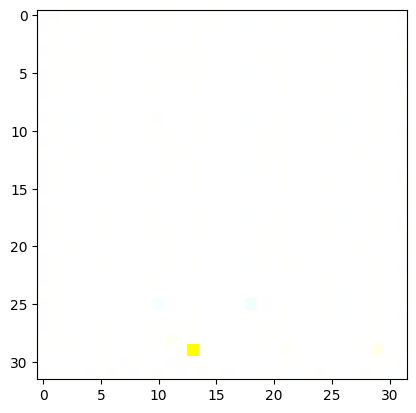

[1/500][0/1181]	Loss_D: -0.1629	Loss_G: 0.0009	LR: 0.004443010	D(G(z)): 0.0000 / 0.0000
[1/500][15/1181]	Loss_D: -0.0423	Loss_G: 0.1060	LR: 0.004436350	D(G(z)): 0.0000 / 0.0000
[1/500][30/1181]	Loss_D: -0.1305	Loss_G: 0.1009	LR: 0.004429700	D(G(z)): 0.0000 / 0.0000
[1/500][45/1181]	Loss_D: -0.0951	Loss_G: 0.2234	LR: 0.004423060	D(G(z)): 0.0000 / 0.0000
[1/500][60/1181]	Loss_D: -0.1124	Loss_G: 0.1748	LR: 0.004416430	D(G(z)): 0.0000 / 0.0000
[1/500][75/1181]	Loss_D: -0.1671	Loss_G: 0.1104	LR: 0.004409810	D(G(z)): 0.0000 / 0.0000
[1/500][90/1181]	Loss_D: -0.0549	Loss_G: 0.0887	LR: 0.004403200	D(G(z)): 0.0000 / 0.0000
[1/500][105/1181]	Loss_D: -0.1211	Loss_G: 0.1035	LR: 0.004396600	D(G(z)): 0.0000 / 0.0000
[1/500][120/1181]	Loss_D: -0.0081	Loss_G: 0.1281	LR: 0.004390010	D(G(z)): 0.0000 / 0.0000
[1/500][135/1181]	Loss_D: -0.1633	Loss_G: 0.0603	LR: 0.004383429	D(G(z)): 0.0000 / 0.0000
[1/500][150/1181]	Loss_D: -0.1127	Loss_G: 0.0806	LR: 0.004376859	D(G(z)): 0.0000 / 0.0000
[1/500][165/1181]	

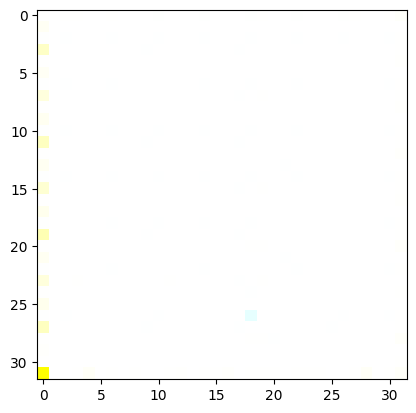

[2/500][0/1181]	Loss_D: -0.1004	Loss_G: -0.1093	LR: 0.003948067	D(G(z)): 0.0000 / 0.0000
[2/500][15/1181]	Loss_D: -0.0794	Loss_G: 0.1133	LR: 0.003942149	D(G(z)): 0.0000 / 0.0000
[2/500][30/1181]	Loss_D: -0.1443	Loss_G: 0.0481	LR: 0.003936240	D(G(z)): 0.0000 / 0.0000
[2/500][45/1181]	Loss_D: -0.0298	Loss_G: -0.1514	LR: 0.003930340	D(G(z)): 0.0000 / 0.0000
[2/500][60/1181]	Loss_D: -0.1584	Loss_G: 0.1578	LR: 0.003924448	D(G(z)): 0.0000 / 0.0000
[2/500][75/1181]	Loss_D: -0.0195	Loss_G: 0.0007	LR: 0.003918566	D(G(z)): 0.0000 / 0.0000
[2/500][90/1181]	Loss_D: -0.1437	Loss_G: 0.0582	LR: 0.003912692	D(G(z)): 0.0000 / 0.0000
[2/500][105/1181]	Loss_D: -0.2153	Loss_G: 0.0895	LR: 0.003906827	D(G(z)): 0.0000 / 0.0000
[2/500][120/1181]	Loss_D: -0.1103	Loss_G: 0.1117	LR: 0.003900971	D(G(z)): 0.0000 / 0.0000
[2/500][135/1181]	Loss_D: -0.0312	Loss_G: -0.0125	LR: 0.003895124	D(G(z)): 0.0000 / 0.0000
[2/500][150/1181]	Loss_D: -0.1738	Loss_G: -0.0369	LR: 0.003889285	D(G(z)): 0.0000 / 0.0000
[2/500][165/11

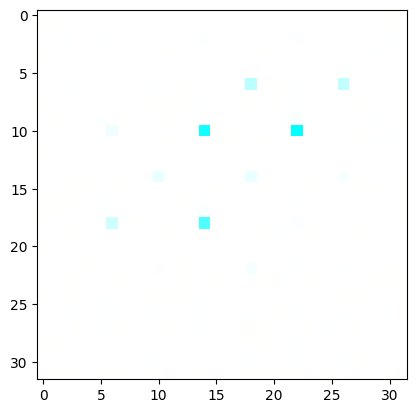

[3/500][0/1181]	Loss_D: -0.1543	Loss_G: -0.0088	LR: 0.003508260	D(G(z)): 0.0000 / 0.0000
[3/500][15/1181]	Loss_D: -0.0649	Loss_G: 0.1926	LR: 0.003503001	D(G(z)): 0.0000 / 0.0000
[3/500][30/1181]	Loss_D: -0.1225	Loss_G: 0.1000	LR: 0.003497750	D(G(z)): 0.0000 / 0.0000
[3/500][45/1181]	Loss_D: -0.1565	Loss_G: 0.2787	LR: 0.003492508	D(G(z)): 0.0000 / 0.0000
[3/500][60/1181]	Loss_D: -0.2131	Loss_G: 0.1429	LR: 0.003487272	D(G(z)): 0.0000 / 0.0000
[3/500][75/1181]	Loss_D: 0.0047	Loss_G: 0.1498	LR: 0.003482045	D(G(z)): 0.0000 / 0.0000
[3/500][90/1181]	Loss_D: -0.1867	Loss_G: 0.0130	LR: 0.003476826	D(G(z)): 0.0000 / 0.0000
[3/500][105/1181]	Loss_D: -0.1657	Loss_G: 0.0501	LR: 0.003471614	D(G(z)): 0.0000 / 0.0000
[3/500][120/1181]	Loss_D: -0.0501	Loss_G: 0.2403	LR: 0.003466410	D(G(z)): 0.0000 / 0.0000
[3/500][135/1181]	Loss_D: -0.0662	Loss_G: 0.2128	LR: 0.003461214	D(G(z)): 0.0000 / 0.0000
[3/500][150/1181]	Loss_D: -0.0652	Loss_G: 0.1065	LR: 0.003456026	D(G(z)): 0.0000 / 0.0000
[3/500][165/1181]	

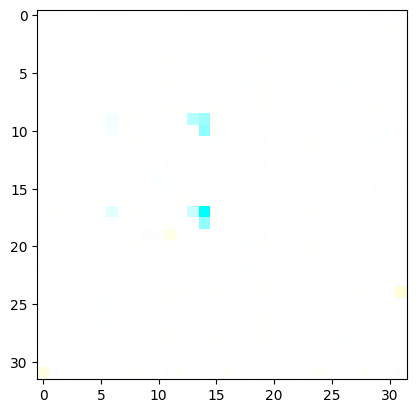

[4/500][0/1181]	Loss_D: -0.1301	Loss_G: 0.2519	LR: 0.003117447	D(G(z)): 0.0000 / 0.0000
[4/500][15/1181]	Loss_D: -0.1073	Loss_G: -0.0678	LR: 0.003112774	D(G(z)): 0.0000 / 0.0000
[4/500][30/1181]	Loss_D: -0.1112	Loss_G: 0.0346	LR: 0.003108108	D(G(z)): 0.0000 / 0.0000
[4/500][45/1181]	Loss_D: -0.1757	Loss_G: 0.1343	LR: 0.003103449	D(G(z)): 0.0000 / 0.0000
[4/500][60/1181]	Loss_D: -0.1172	Loss_G: 0.1243	LR: 0.003098797	D(G(z)): 0.0000 / 0.0000
[4/500][75/1181]	Loss_D: -0.1471	Loss_G: 0.0621	LR: 0.003094152	D(G(z)): 0.0000 / 0.0000
[4/500][90/1181]	Loss_D: -0.0117	Loss_G: 0.0497	LR: 0.003089514	D(G(z)): 0.0000 / 0.0000
[4/500][105/1181]	Loss_D: -0.1471	Loss_G: 0.0590	LR: 0.003084883	D(G(z)): 0.0000 / 0.0000
[4/500][120/1181]	Loss_D: -0.0370	Loss_G: 0.0495	LR: 0.003080259	D(G(z)): 0.0000 / 0.0000
[4/500][135/1181]	Loss_D: -0.0579	Loss_G: 0.1508	LR: 0.003075642	D(G(z)): 0.0000 / 0.0000
[4/500][150/1181]	Loss_D: -0.0134	Loss_G: 0.1257	LR: 0.003071032	D(G(z)): 0.0000 / 0.0000
[4/500][165/1181]

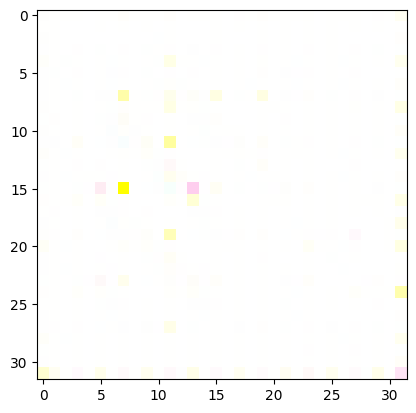

[5/500][0/1181]	Loss_D: -0.2069	Loss_G: 0.1621	LR: 0.002770169	D(G(z)): 0.0000 / 0.0000
[5/500][15/1181]	Loss_D: -0.0160	Loss_G: 0.1294	LR: 0.002766017	D(G(z)): 0.0000 / 0.0000
[5/500][30/1181]	Loss_D: -0.1265	Loss_G: -0.0111	LR: 0.002761871	D(G(z)): 0.0000 / 0.0000
[5/500][45/1181]	Loss_D: -0.2057	Loss_G: 0.1560	LR: 0.002757731	D(G(z)): 0.0000 / 0.0000
[5/500][60/1181]	Loss_D: -0.1628	Loss_G: 0.1579	LR: 0.002753597	D(G(z)): 0.0000 / 0.0000
[5/500][75/1181]	Loss_D: -0.1959	Loss_G: 0.0697	LR: 0.002749470	D(G(z)): 0.0000 / 0.0000
[5/500][90/1181]	Loss_D: 0.0361	Loss_G: 0.1139	LR: 0.002745348	D(G(z)): 0.0000 / 0.0000
[5/500][105/1181]	Loss_D: -0.1750	Loss_G: 0.0147	LR: 0.002741233	D(G(z)): 0.0000 / 0.0000
[5/500][120/1181]	Loss_D: -0.1948	Loss_G: 0.0224	LR: 0.002737124	D(G(z)): 0.0000 / 0.0000
[5/500][135/1181]	Loss_D: -0.2710	Loss_G: 0.0997	LR: 0.002733021	D(G(z)): 0.0000 / 0.0000
[5/500][150/1181]	Loss_D: -0.2006	Loss_G: 0.2102	LR: 0.002728925	D(G(z)): 0.0000 / 0.0000
[5/500][165/1181]	

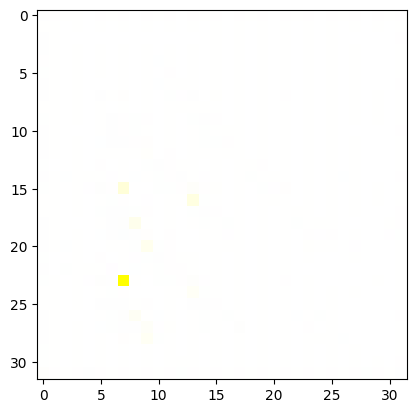

[6/500][0/1181]	Loss_D: -0.1830	Loss_G: 0.1219	LR: 0.002461578	D(G(z)): 0.0000 / 0.0000
[6/500][15/1181]	Loss_D: -0.0427	Loss_G: -0.1148	LR: 0.002457888	D(G(z)): 0.0000 / 0.0000
[6/500][30/1181]	Loss_D: -0.2478	Loss_G: 0.2320	LR: 0.002454204	D(G(z)): 0.0000 / 0.0000
[6/500][45/1181]	Loss_D: -0.2443	Loss_G: 0.2964	LR: 0.002450525	D(G(z)): 0.0000 / 0.0000
[6/500][60/1181]	Loss_D: -0.3041	Loss_G: 0.3294	LR: 0.002446852	D(G(z)): 0.0000 / 0.0000
[6/500][75/1181]	Loss_D: -0.1745	Loss_G: 0.0745	LR: 0.002443184	D(G(z)): 0.0000 / 0.0000
[6/500][90/1181]	Loss_D: -0.1302	Loss_G: -0.0762	LR: 0.002439522	D(G(z)): 0.0000 / 0.0000
[6/500][105/1181]	Loss_D: -0.2826	Loss_G: -0.0558	LR: 0.002435865	D(G(z)): 0.0000 / 0.0000
[6/500][120/1181]	Loss_D: -0.2137	Loss_G: 0.0516	LR: 0.002432214	D(G(z)): 0.0000 / 0.0000
[6/500][135/1181]	Loss_D: -0.0521	Loss_G: 0.0995	LR: 0.002428568	D(G(z)): 0.0000 / 0.0000
[6/500][150/1181]	Loss_D: -0.1790	Loss_G: 0.0970	LR: 0.002424928	D(G(z)): 0.0000 / 0.0000
[6/500][165/118

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

batch_size = 4
num_epochs = 500

gamma = 0.9999

schedulerG = torch.optim.lr_scheduler.ExponentialLR(optimizerG, gamma, last_epoch=-1)
schedulerC = torch.optim.lr_scheduler.ExponentialLR(opt_critic, gamma, last_epoch=-1)

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    batch_count = int(np.ceil(sample_count / batch_size))
    permutation = np.random.permutation(sample_count)
    for batch_idx in range(batch_count):
        print("epoch: {} \t {}/{} batch".format(epoch, batch_idx, batch_count), end="\r")

        batch_start = batch_idx * batch_size
        batch_end = min(sample_count, (batch_idx + 1) * batch_size)
        batch_indeces = permutation[batch_start:batch_end]
        real_batch_size = batch_end - batch_start

        data = dataset_t[batch_indeces]
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch, uncomment for GAN
        # netD.zero_grad()
        # Format batch
        real_cpu = data
        # label = torch.full((real_batch_size,), real_label, dtype=torch.float)
        # if USE_CUDA:
        #     label = label.cuda()
        # # Forward pass real batch through D
        # output = netD(real_cpu).view(-1)
        # # Calculate loss on all-real batch
        # errD_real = criterion(output, label)
        # # Calculate gradients for D in backward pass
        # errD_real.backward()
        # D_x = output.mean().item()

        loss_critic = None

        for _ in range(critic_iterations):
          ## Train with all-fake batch
          # Generate batch of latent vectors
          noise = torch.randn(real_batch_size, nz, noise_h, noise_w)
          if USE_CUDA:
              noise = noise.cuda()
          # Generate fake image batch with G
          fake = netG(noise)

          # For WGAN- someone confirm for me that real_cpu is the right argument here.
          critic_real = critic(real_cpu).reshape(-1)
          critic_fake = critic(fake).reshape(-1)
          loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
          critic.zero_grad()
          loss_critic.backward(retain_graph=True)
          opt_critic.step()

          for p in critic.parameters(): p.data.clamp_(- weight_clip, weight_clip)

        # Train generator: min -E[critic(gen_fake)]
        output = critic(fake).reshape(-1)
        loss_gen = - torch.mean(output)
        netG.zero_grad()
        loss_gen.backward()
        optimizerG.step()

        # label.fill_(fake_label)
        # # Classify all fake batch with D
        # output = netD(fake.detach()).view(-1)
        # # Calculate D's loss on the all-fake batch
        # errD_fake = criterion(output, label)
        # # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        # errD_fake.backward()
        D_G_z1 = output.mean().item()
        # # Compute error of D as sum over the fake and the real batches
        # errD = errD_real + errD_fake
        # # Update D
        # optimizerD.step()

        # ############################
        # # (2) Update G network: maximize log(D(G(z)))
        # ###########################
        # netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        # # Since we just updated D, perform another forward pass of all-fake batch through D
        # output = netD(fake).view(-1)
        # # Calculate G's loss based on this output
        # errG = criterion(output, label)
        # # Calculate gradients for G
        # errG.backward()
        D_G_z2 = output.mean().item()
        # # Update G
        # optimizerG.step()

        # Output training stats
        if batch_idx % 15 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLR: %.9f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, batch_idx, batch_count, loss_critic.item(), loss_gen.item(), optimizerG.param_groups[0]['lr'], 0, 0))
            # Replaced errD.item(), errG.item(), D_x, D_G_z1, and D_G_z2 with 0s in the print statement for WGAN.

        # # Save Losses for plotting later
        # G_losses.append(errG.item())
        # D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (batch_idx == batch_count - 1 ):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(fake.numpy())
            index = 0
            img = fake.numpy()[0]
            img = np.moveaxis(img, 0, -1)
            img = (img - img.min()) / (img.max() - img.min())

            plt.imshow(img)
            plt.show()

        schedulerC.step()
        schedulerG.step()

        # print("G lr: ", optimizerG.param_groups[0]['lr'], "; C lr:", opt_critic.param_groups[0]['lr'])


        iters += 1

(32, 32, 3)


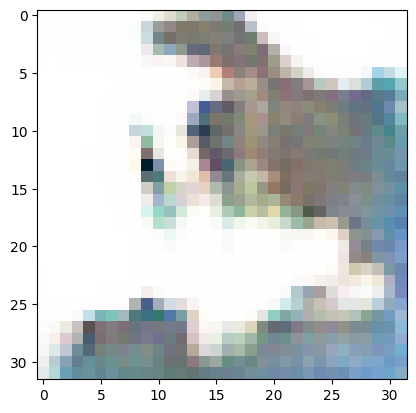

(32, 32, 3)


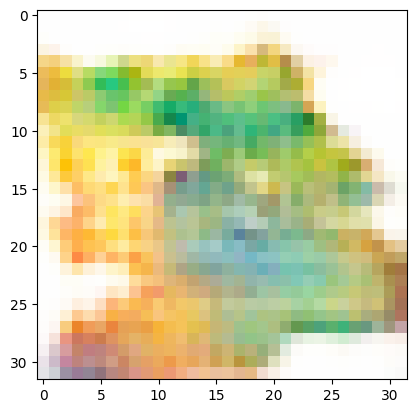

(32, 32, 3)


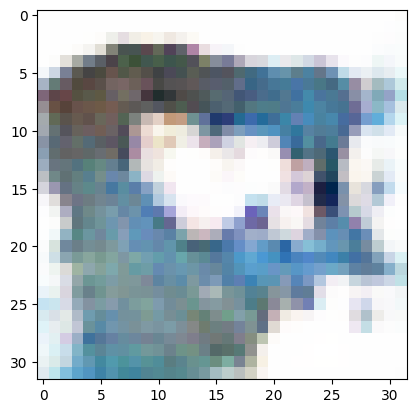

(32, 32, 3)


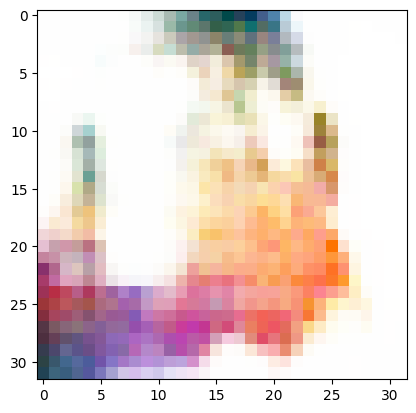

(32, 32, 3)


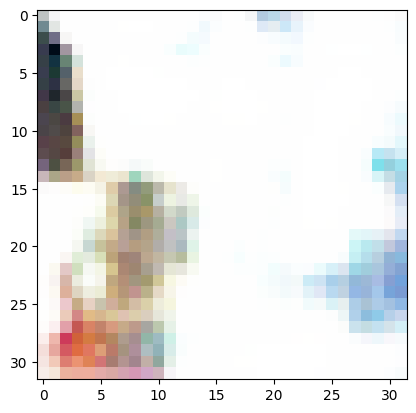

(32, 32, 3)


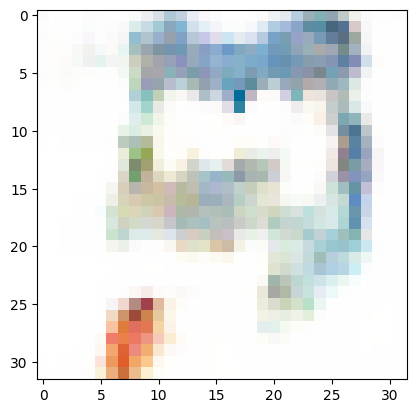

(32, 32, 3)


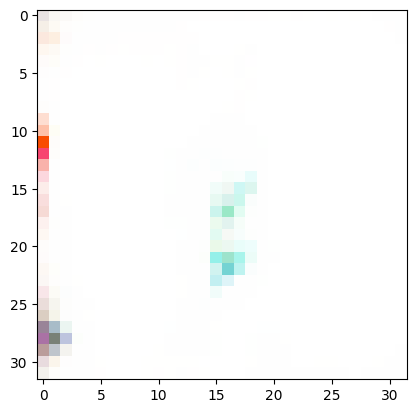

(32, 32, 3)


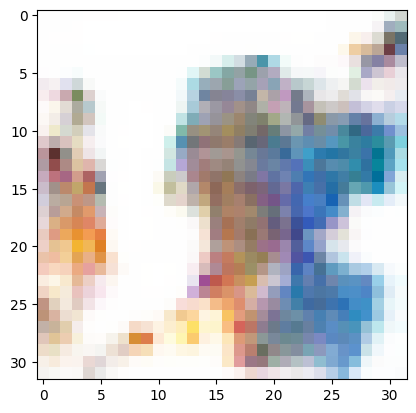

(32, 32, 3)


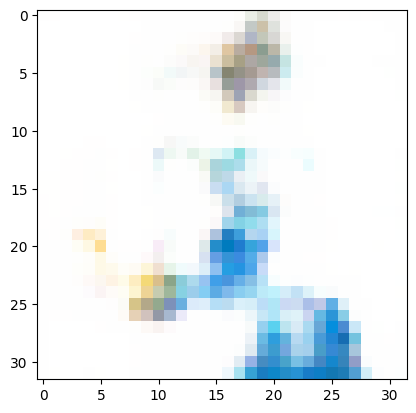

(32, 32, 3)


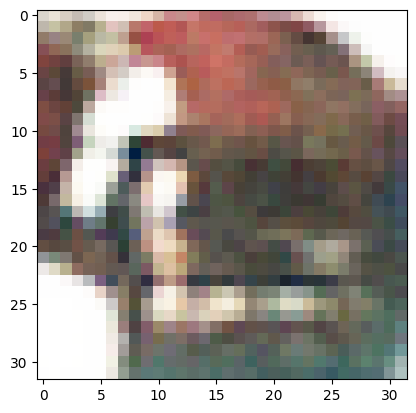

(32, 32, 3)


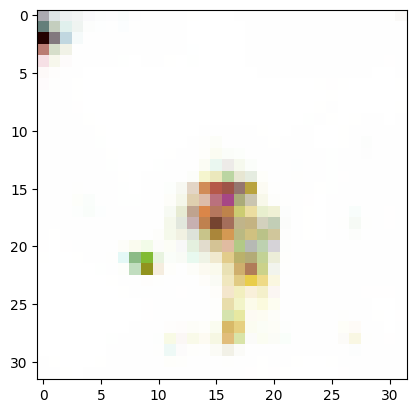

(32, 32, 3)


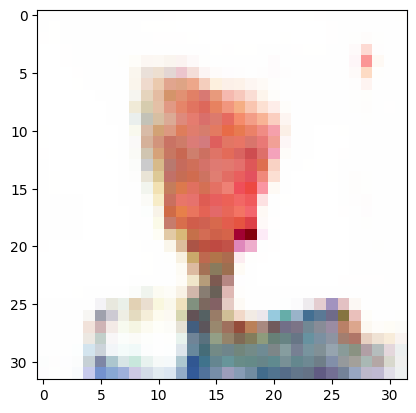

(32, 32, 3)


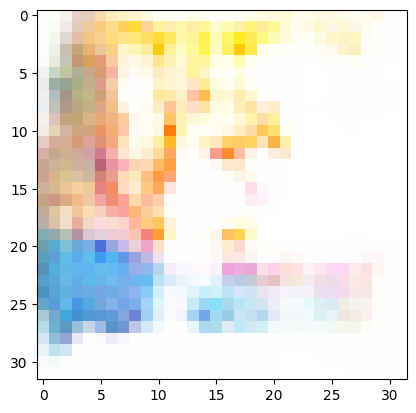

(32, 32, 3)


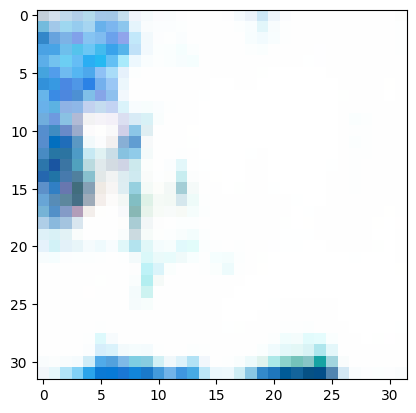

(32, 32, 3)


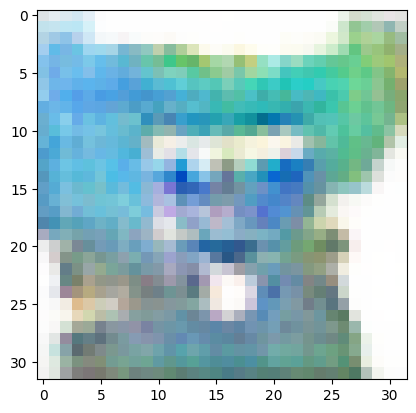

(32, 32, 3)


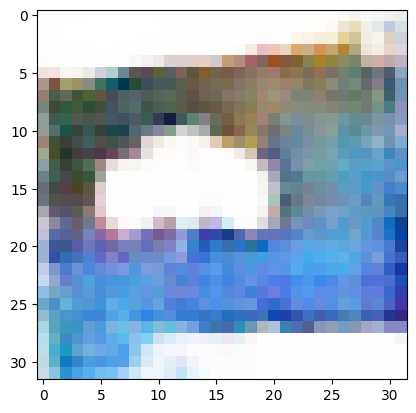

(32, 32, 3)


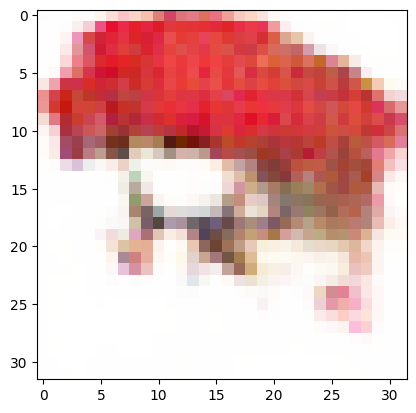

(32, 32, 3)


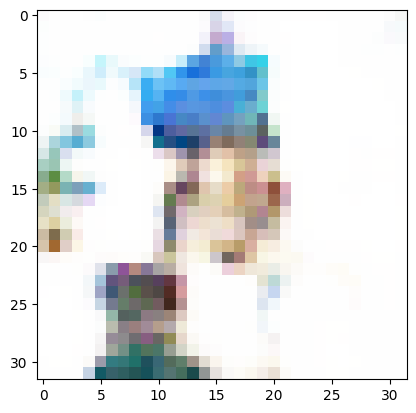

(32, 32, 3)


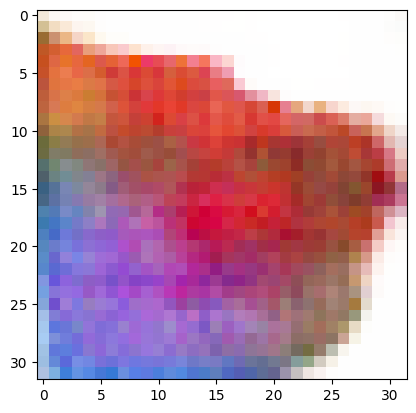

(32, 32, 3)


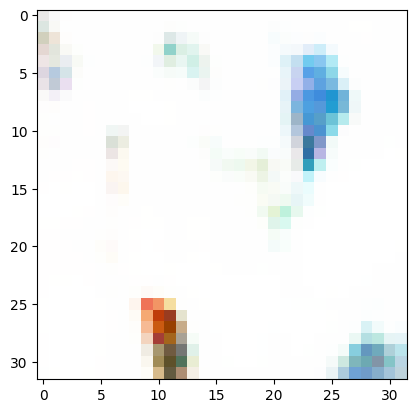

(32, 32, 3)


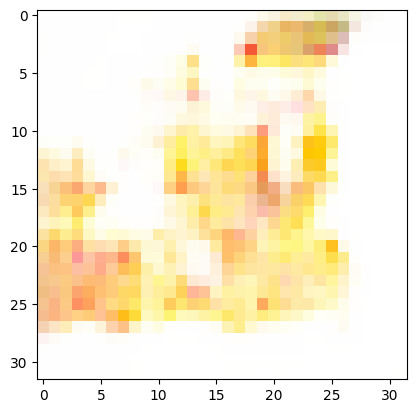

(32, 32, 3)


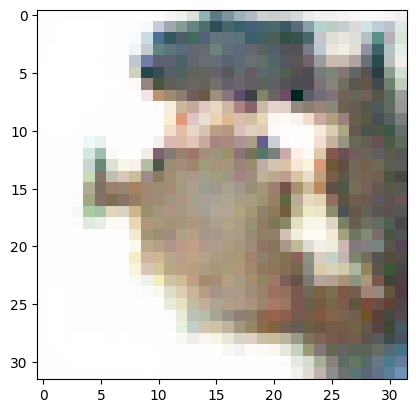

(32, 32, 3)


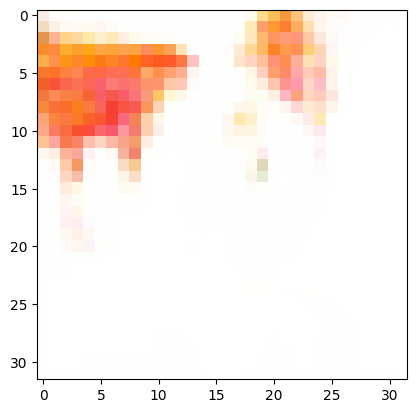

(32, 32, 3)


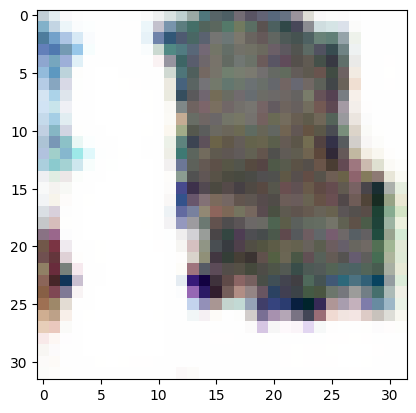

(32, 32, 3)


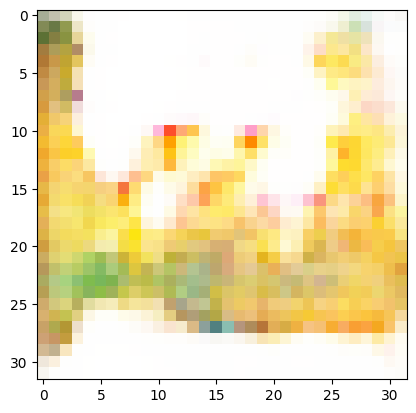

(32, 32, 3)


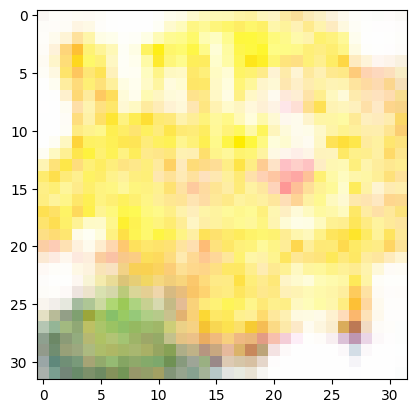

(32, 32, 3)


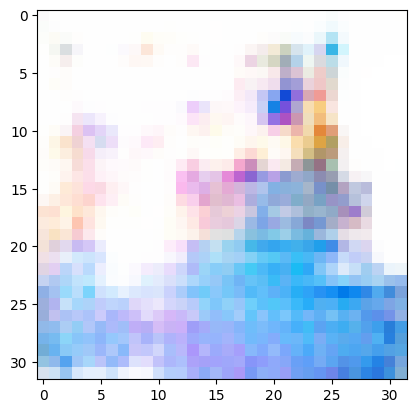

(32, 32, 3)


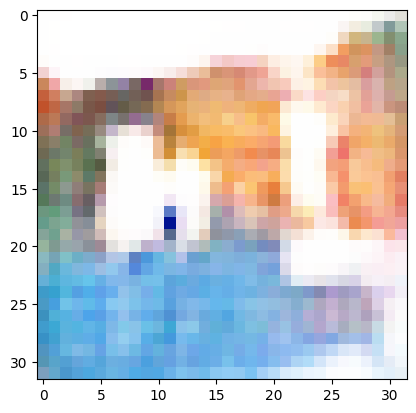

(32, 32, 3)


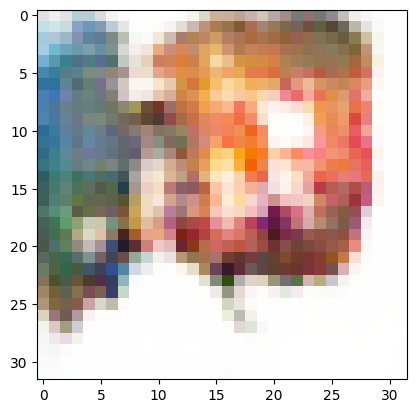

(32, 32, 3)


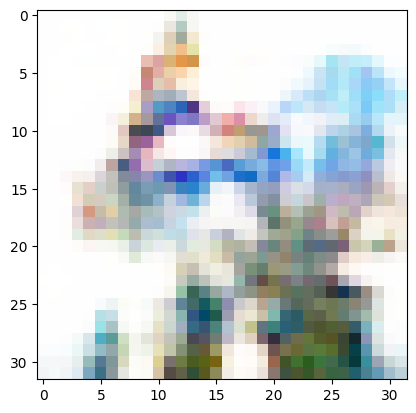

(32, 32, 3)


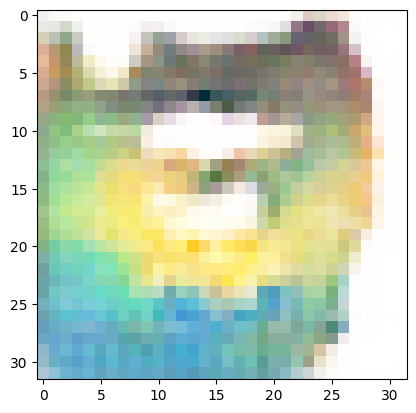

(32, 32, 3)


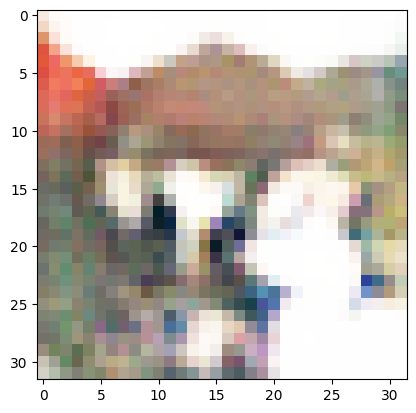

(32, 32, 3)


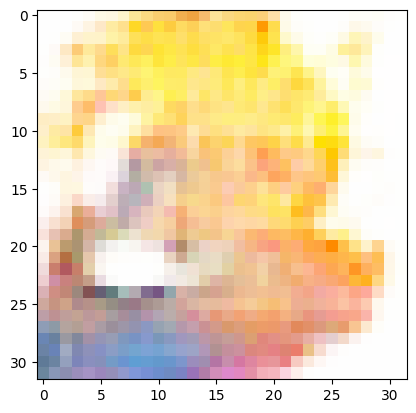

(32, 32, 3)


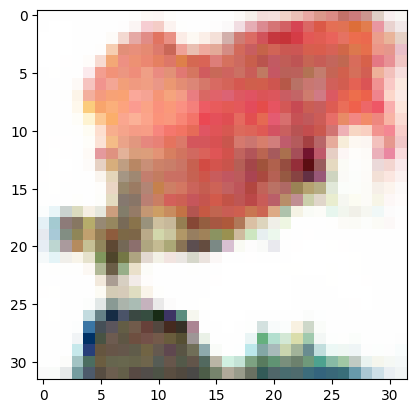

(32, 32, 3)


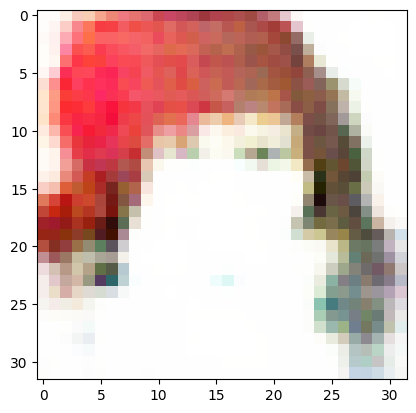

(32, 32, 3)


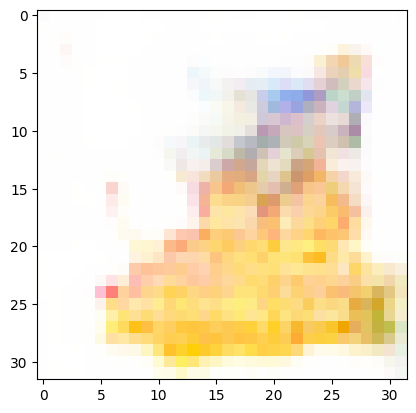

(32, 32, 3)


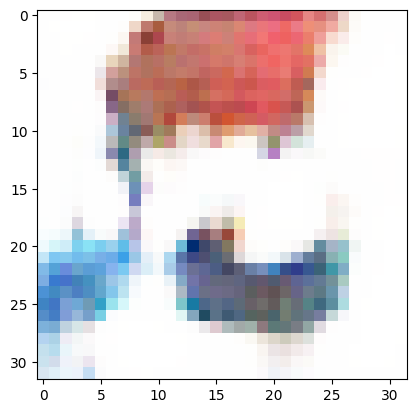

(32, 32, 3)


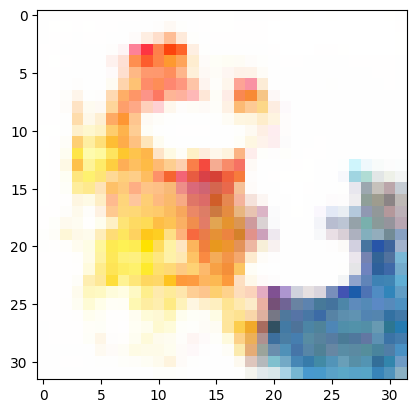

(32, 32, 3)


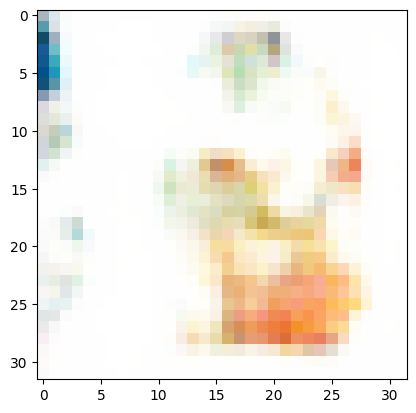

(32, 32, 3)


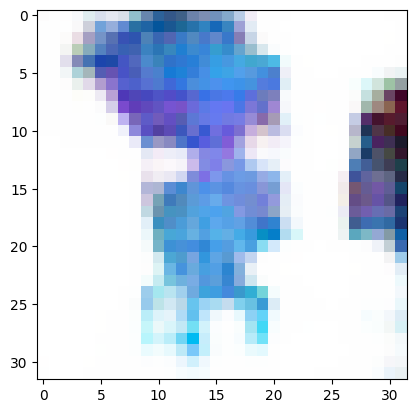

(32, 32, 3)


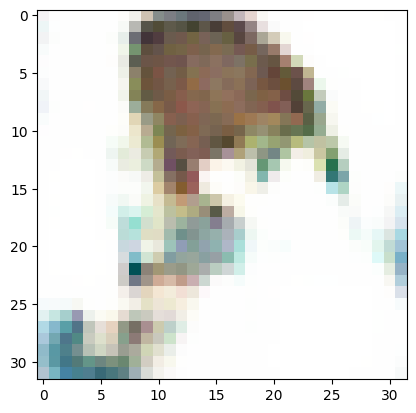

(32, 32, 3)


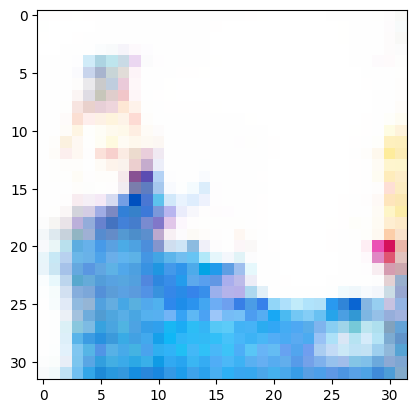

(32, 32, 3)


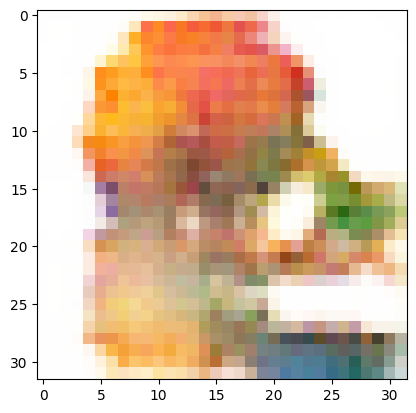

(32, 32, 3)


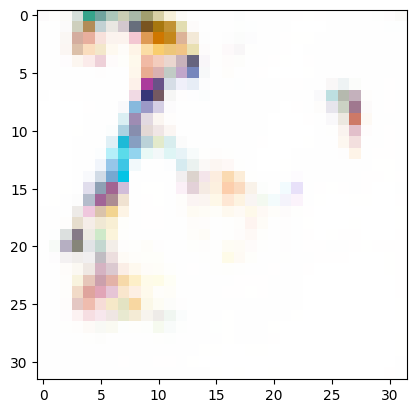

(32, 32, 3)


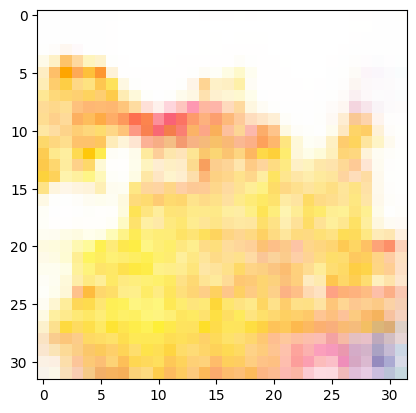

(32, 32, 3)


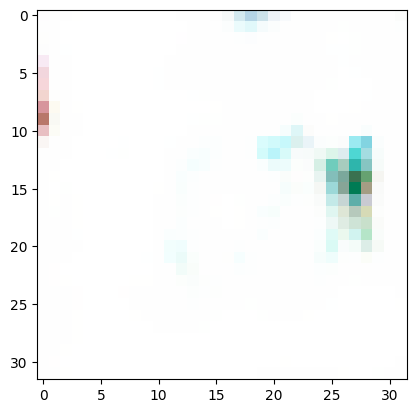

(32, 32, 3)


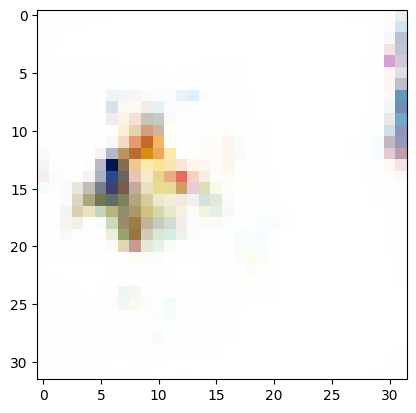

(32, 32, 3)


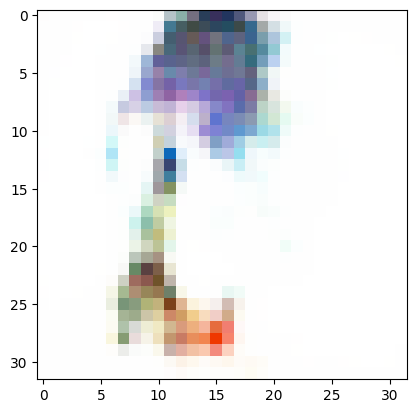

(32, 32, 3)


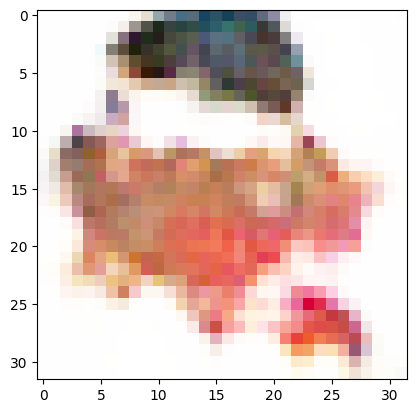

(32, 32, 3)


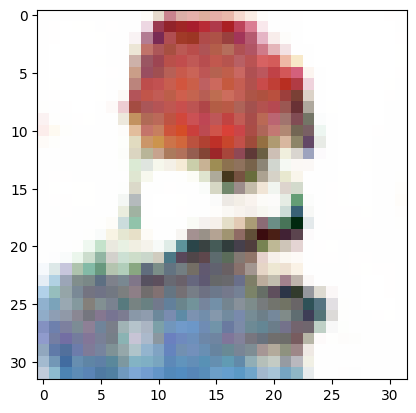

(32, 32, 3)


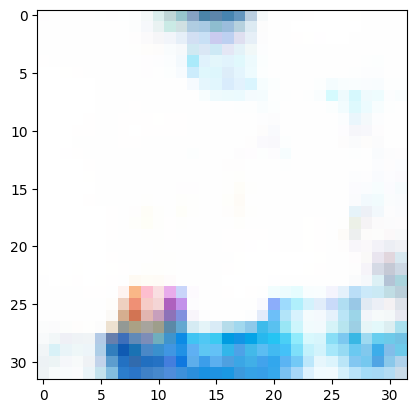

(32, 32, 3)


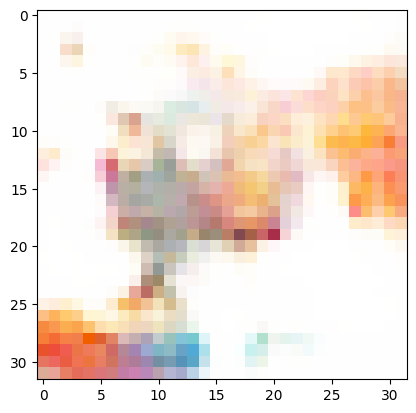

(32, 32, 3)


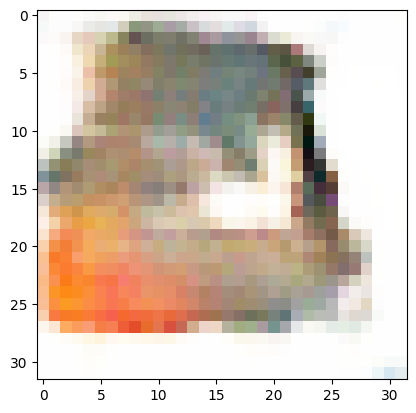

(32, 32, 3)


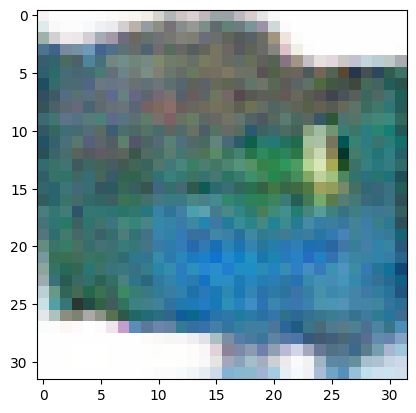

(32, 32, 3)


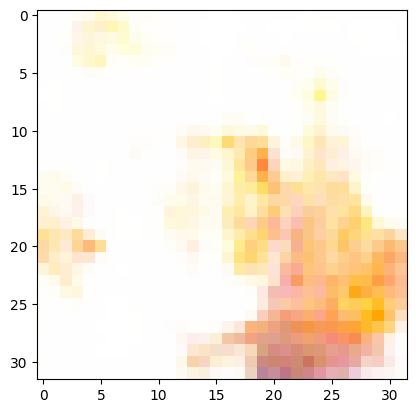

(32, 32, 3)


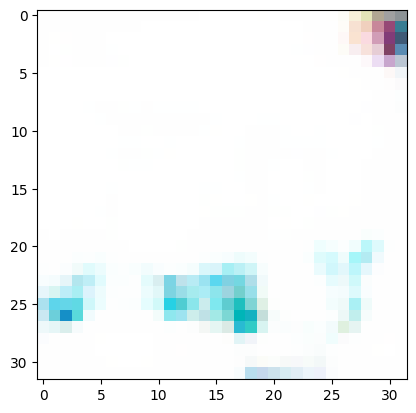

(32, 32, 3)


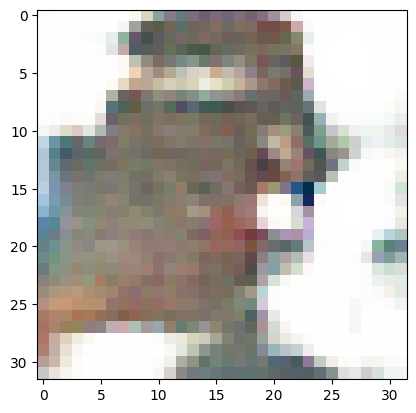

(32, 32, 3)


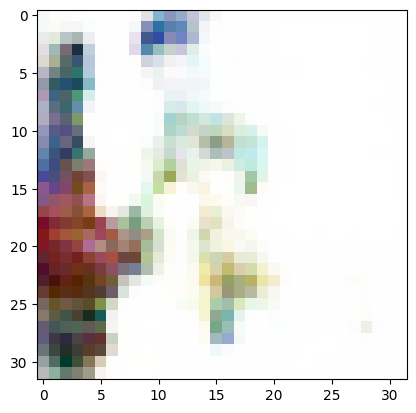

(32, 32, 3)


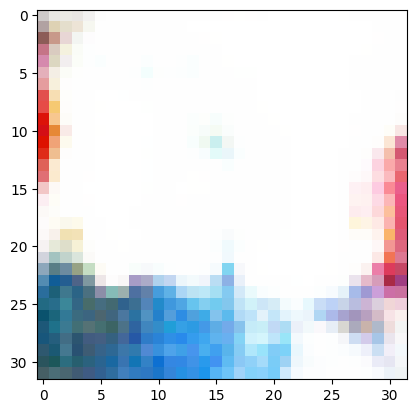

(32, 32, 3)


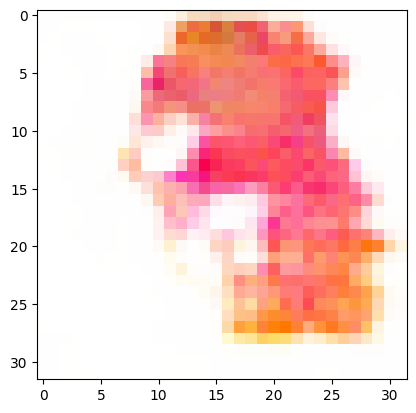

(32, 32, 3)


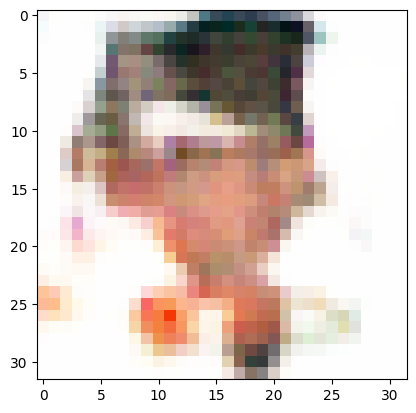

(32, 32, 3)


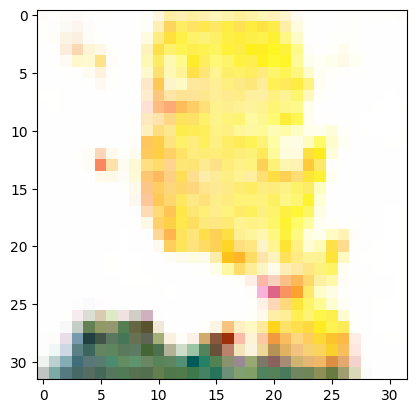

(32, 32, 3)


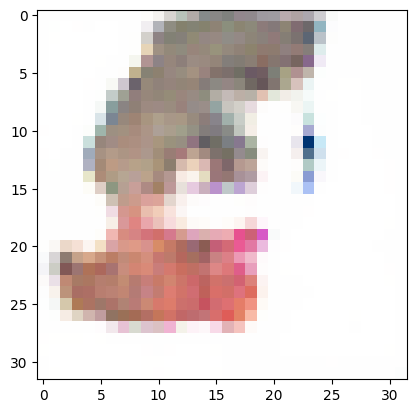

(32, 32, 3)


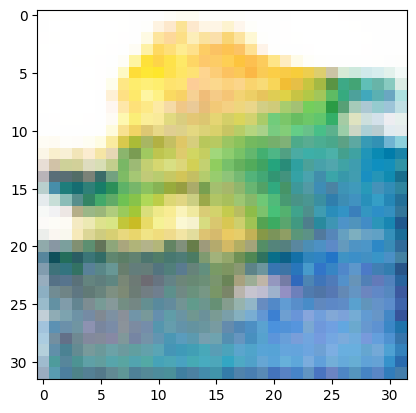

In [20]:
for img in img_list[16]:
    img = np.moveaxis(img, 0, -1)
    img = (img - img.min()) / (img.max() - img.min())

    print(img.shape)
    plt.imshow(img)
    plt.show()